#Задание 1. Сформировать отчёт с информацией о 10 наиболее популярных языках программирования по итогам года за период с 2010 по 2020 годы.

In [60]:
import pyspark.sql.functions as F
from pyspark.sql import Row
from pyspark.sql import SparkSession

import os
import sys

In [61]:
# Задаем переменные окружения для корректной работы некоторых функций
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Задаем переменную окружения для парсинга xml
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.12:0.17.0 pyspark-shell'

os.chdir('../')

In [62]:
spark = SparkSession.builder.getOrCreate()
spark

In [63]:
def show_info(data):

    print("\033[1mПервые 5 элементов\033[0m")
    data.show(n = 5)

    print("\033[1mКоличество элементов\033[0m")
    print(data.count())

In [64]:
def get_path_to_file(file_name):
    return f'file:///{os.getcwd()}/{file_name}'.replace("\\", "/")

In [65]:
postsData = spark.read.format('xml').option('rowTag', 'row').option("timestampFormat", 'y/M/d H:m:s').load('/content/posts_sample.xml')
show_info(postsData)

Первые 5 элементов
+-----------------+------------+--------------------+-----------+-------------+--------------------+--------------------+--------------+---+--------------------+--------------------+----------------------+-----------------+-----------------+------------+---------+-----------+------+--------------------+--------------------+----------+
|_AcceptedAnswerId|_AnswerCount|               _Body|_ClosedDate|_CommentCount| _CommunityOwnedDate|       _CreationDate|_FavoriteCount|_Id|   _LastActivityDate|       _LastEditDate|_LastEditorDisplayName|_LastEditorUserId|_OwnerDisplayName|_OwnerUserId|_ParentId|_PostTypeId|_Score|               _Tags|              _Title|_ViewCount|
+-----------------+------------+--------------------+-----------+-------------+--------------------+--------------------+--------------+---+--------------------+--------------------+----------------------+-----------------+-----------------+------------+---------+-----------+------+--------------------+---

In [66]:
dates = ("2010-01-01",  "2020-12-31")

posts_by_date = postsData.filter(F.col("_CreationDate").between(*dates))
posts_by_date.show(5)



+-----------------+------------+--------------------+-----------+-------------+-------------------+--------------------+--------------+-------+--------------------+--------------------+----------------------+-----------------+-----------------+------------+---------+-----------+------+-----+------+----------+
|_AcceptedAnswerId|_AnswerCount|               _Body|_ClosedDate|_CommentCount|_CommunityOwnedDate|       _CreationDate|_FavoriteCount|    _Id|   _LastActivityDate|       _LastEditDate|_LastEditorDisplayName|_LastEditorUserId|_OwnerDisplayName|_OwnerUserId|_ParentId|_PostTypeId|_Score|_Tags|_Title|_ViewCount|
+-----------------+------------+--------------------+-----------+-------------+-------------------+--------------------+--------------+-------+--------------------+--------------------+----------------------+-----------------+-----------------+------------+---------+-----------+------+-----+------+----------+
|             NULL|        NULL|<p>No. (And more ...|       NULL|  

In [72]:
languagesData = spark.read.format('csv').option('header', 'true').option("inferSchema", True).load(get_path_to_file('/programming-languages.csv')).dropna()
show_info(languagesData)

Первые 5 элементов
+----------+--------------------+
|      name|       wikipedia_url|
+----------+--------------------+
|   A# .NET|https://en.wikipe...|
|A# (Axiom)|https://en.wikipe...|
|A-0 System|https://en.wikipe...|
|        A+|https://en.wikipe...|
|       A++|https://en.wikipe...|
+----------+--------------------+
only showing top 5 rows

Количество элементов
699


In [73]:
language_names = [str(x[0]) for x in languagesData.collect()]

def includes_name(x):              # определение языка, который содержится в теге поста
    tag = None
    for name in language_names:
        n = '<' + name.lower() + '>'
        if n in str(x._Tags).lower():
            tag = name
            break
    if tag is None:
        tag = 'No'

    return (x[6], tag)

posts_by_date_rdd = posts_by_date.rdd.map(includes_name).filter(lambda x: x[1] != 'No')

posts_by_date_rdd_group = posts_by_date_rdd.keyBy(lambda row: (row[0].year, row[1])).aggregateByKey(0, lambda x, y: x + 1, lambda x1, x2: x1 + x2).sortBy(lambda x: x[1], ascending=False).collect()

years_list = [i for i in range(2010, 2020)][::-1]
df_by_years = []
for year in years_list:
    df_by_years.extend([row for row in posts_by_date_rdd_group if row[0][0] == year][:10])


In [74]:
row_template = Row('Year', 'Language', 'Count')                  # полученные данные записываем в строки
result_df = spark.createDataFrame([row_template(*x, y) for x, y in df_by_years])   # создаем новую таблицу с данными

In [78]:
result_df.show(100) # все топ-10 за 2010-2021 год

+----+-----------+-----+
|Year|   Language|Count|
+----+-----------+-----+
|2019|     Python|  162|
|2019| JavaScript|  131|
|2019|       Java|   95|
|2019|        PHP|   59|
|2019|          R|   36|
|2019|          C|   14|
|2019|       Dart|    9|
|2019|     MATLAB|    9|
|2019|         Go|    9|
|2019|       Bash|    8|
|2018|     Python|  214|
|2018| JavaScript|  196|
|2018|       Java|  145|
|2018|        PHP|   99|
|2018|          R|   63|
|2018|          C|   24|
|2018|      Scala|   22|
|2018| TypeScript|   21|
|2018| PowerShell|   13|
|2018|       Bash|   12|
|2017| JavaScript|  244|
|2017|       Java|  204|
|2017|     Python|  185|
|2017|        PHP|  122|
|2017|          R|   53|
|2017|          C|   24|
|2017|Objective-C|   19|
|2017|       Ruby|   16|
|2017| TypeScript|   14|
|2017| PowerShell|   14|
|2016| JavaScript|  272|
|2016|       Java|  179|
|2016|     Python|  141|
|2016|        PHP|  126|
|2016|          R|   50|
|2016|          C|   32|
|2016|       Ruby|   21|


# Задание 2. Получившийся отчёт сохранить в формате Apache Parquet.

In [76]:
os.chdir('/content/LR2')  # переходим в папку LR2

In [77]:
result_df.write.mode("overwrite").parquet(get_path_to_file("top_ten_languages.parquet")) # сохраняем отчет

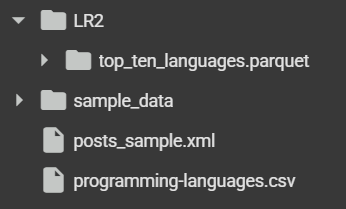